In [122]:
# https://www.kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus?select=restaurant-menus.csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt




(3375211, 5)

In [ ]:
def PrzetworzKategorie(df):
    # nazwy kategorii restauracji zmniejszam do małych liter, oraz rozdzielam do nowych kolumn o nazwach od 0 - 29
    df=df.join(df['category'].str.lower().str.split(',', expand=True))

    df.drop('category', axis=1, inplace=True)

#Tworze kolumny dla każdej osobnej kategorii restauracji
    df_cat_rest=pd.get_dummies(df, drop_first = False, columns= [x for x in range(0,30)], prefix_sep='', prefix='' )


#Sumuje kategorie które dublują się . Nazwy kategorii są w kolumnach o numerach od 8
    df_sum_cat = df_cat_rest.iloc[:,8:].groupby(df_cat_rest.columns[8:], axis=1).sum()
#do tabeli z informacjami o tabeli 
    df_new_rest=df_cat_rest.iloc[:,:8].join(df_sum_cat)
    return df_new_rest

def filter_restaurants(df, price_min=0, price_max=5, score_min=0, position_max=1000):
    con1=df['position']<position_max 
    con2=df['score']>score_min 
    con3=df['price']<price_max 
    con4=df['price']>price_min
    return df[con1 & con2 & con3 & con4]

def create_cat_table(df_sum_cat):
    df_new_sum =df_sum_cat.sum(axis=0).reset_index()
    df_new_sum.columns=['category', 'sum']
    df_cat=df_new_sum.sort_values('sum', ascending= False).set_index('category')
    df_cat.drop(df_cat[df_cat['sum']<1].index, inplace= True)
    df_cat.drop('american', axis=0, inplace=True)
    return df_cat




In [ ]:
df_menu=pd.read_csv('restauracje/restaurant-menus.csv')

df_restaurant=pd.read_csv('restauracje/restaurants.csv')


In [374]:
df_restaurant = df_restaurant.drop(['full_address', 'zip_code'], axis=1)

df_restaurant['price'] = df_restaurant["price_range"].map({None : 0, "$" : 1, "$$" : 2,"$$$" : 3, "$$$$" : 4})
df_restaurant = df_restaurant.drop(['price_range'], axis=1)




KeyError: "['full_address', 'zip_code'] not found in axis"

In [375]:
df_new_rest=PrzetworzKategorie(df_restaurant)

In [373]:
df_filtered= filter_restaurants(df_new_rest, position_max=5, price_min=1, price_max=4, score_min=4.2)



KeyError: 'category'

,sum
category,
american,1743
fast food,1639
convenience,1182
burgers,1105
sandwich,896
...,...
seafood,108
traditional american,105
noodles,104


In [387]:
plt.style.use('Solarize_Light2')

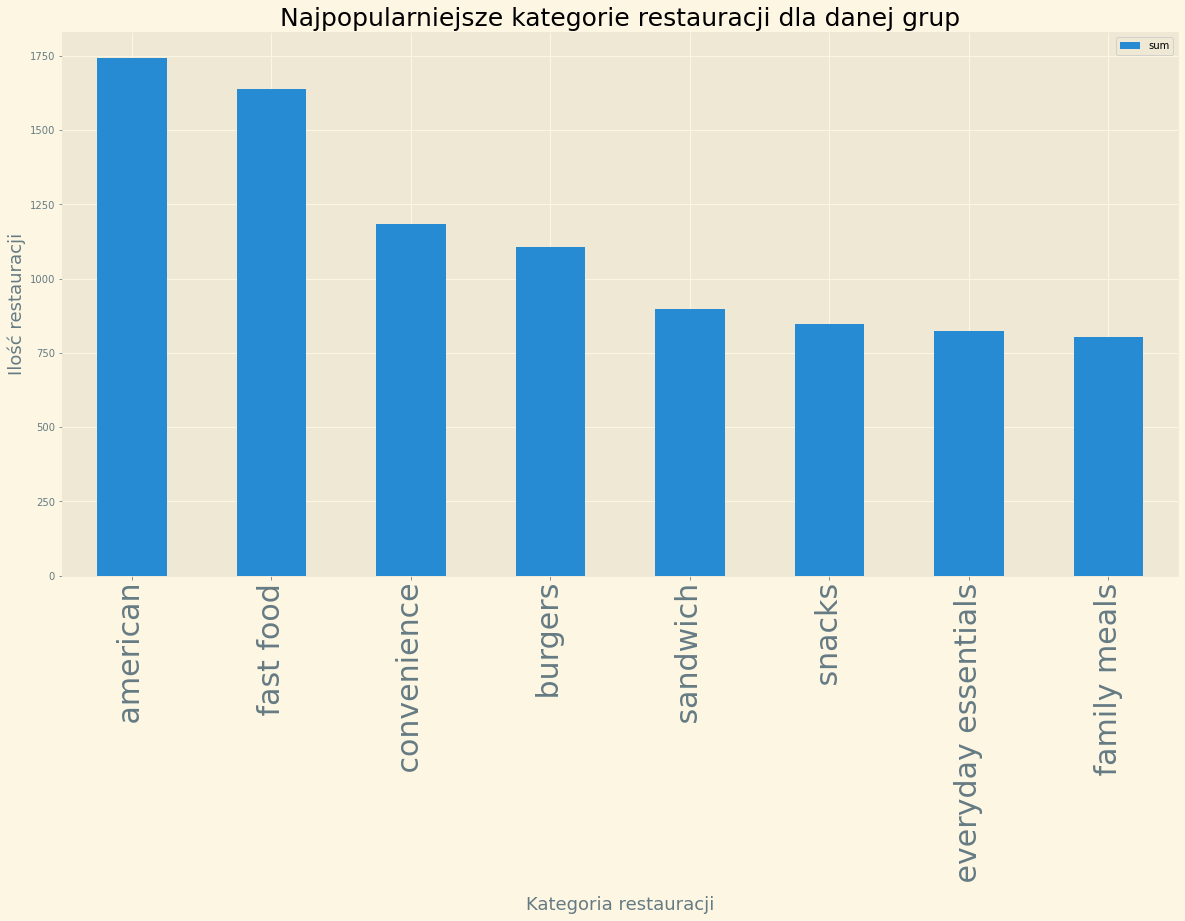

In [395]:
plt.rcParams["figure.figsize"] = (20,10)
data_chart = cat_table.iloc[:8].plot.bar()


data_chart.set_xlabel('Kategoria restauracji', fontsize=18)
data_chart.set_ylabel('Ilość restauracji', fontsize=18)
data_chart.set_title('Najpopularniejsze kategorie restauracji dla danej grup', fontsize=25)
plt.xticks(fontsize=30)
plt.show()

#plt.bar(cat_table.iloc[:10,:].index,cat_table.iloc[:10,0])

In [399]:
# Badanie popularności kategorii dań w restauracjach

df_menu.groupby('category').count().sort_values(['restaurant_id'], ascending=False).head(5)
#df_pop_menu

,restaurant_id,name,description,price
category,,,,
Picked for you,145401,145401,119673,145401
Beverages,103391,103391,47436,103391
Sandwiches,102730,102730,98714,102730
Sides,93354,93354,46435,93354
Drinks,85904,85904,41634,85904


In [401]:
# Łączenie tabelii restauracji z tabelą menu
min_price=1
max_price=4

df_rest_pric=df_restaurant[(df_restaurant['price']>=min_price) & (df_restaurant['price']<=max_price)]
df_rest_merge = pd.merge(df_rest_pric, df_menu, left_on='id', right_on='restaurant_id', how='left')


In [404]:
df_rest_merge

,id,position,name_x,score,ratings,category_x,lat,lng,price_x,restaurant_id,category_y,name_y,description,price_y
0,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large Meat Lovers,Whole pie.,15.99 USD
1,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large Supreme,Whole pie.,15.99 USD
2,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large Pepperoni,Whole pie.,14.99 USD
3,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large BBQ Chicken &amp; Bacon,Whole Pie,15.99 USD
4,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large 5 Cheese,Whole pie.,14.99 USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988227,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Kid’s Mains,Lion Plate,BBQ skewer two pices and fantail shrimp two pi...,8.55 USD
2988228,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Beverages,Soft Drinks,NaN,1.95 USD
2988229,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Beverages,Iced Tea,NaN,1.95 USD
2988230,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Desserts,Sesame Balls (4 pcs),NaN,3.95 USD


In [405]:
# Średnia ilość oraz średnia cena dla kategorii cenowych
tdf=df_rest_merge.groupby('price_x').mean()
tdf['count']=df_rest_merge.groupby('price_x')[['id']].count()
tdf.head()

,id,position,score,ratings,lat,lng,restaurant_id,count
price_x,,,,,,,,
1.0,19858.055020,56.737690,4.577270,80.999936,40.199554,-95.806945,19858.011518,2377072
2.0,19410.385341,69.459569,4.541964,92.630883,39.699136,-94.993482,19410.338148,601154
3.0,18847.982920,112.693774,4.621466,84.195394,40.742407,-94.838126,18847.982920,9075
4.0,18257.350161,85.795918,4.565862,63.829308,40.603967,-97.053543,18257.350161,931
